3 GPU 28 CPU Execution of ResNet 50 model with AMP (Automatic Mixed Precision)

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, DistributedSampler
from torchvision import datasets, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import matplotlib.pyplot as plt
import multiprocessing as mp
import torch.distributed as dist
import torch.cuda.amp as amp  # import for automatic mixed precision
from torchvision.models import resnet50, ResNet50_Weights

In [2]:
world_size = torch.cuda.device_count()
world_size

4

In [3]:
data_dir = '/home/patel.devki1/Dataset/lung_colon_image_set/'  # Updated with our dataset directory
output_dir = '/home/patel.devki1/Dataset'  # Updated with our desired output directory

In [4]:
def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '13285'
    dist.init_process_group("nccl", rank=rank, world_size=world_size)
    torch.cuda.set_device(rank)
    print(f"[Rank {rank}] Initialization complete. Using world size {world_size}.")

def cleanup():
    dist.destroy_process_group()

class LungColonCancerDataset(datasets.ImageFolder):
    def __init__(self, root_dir, transform=None):
        super(LungColonCancerDataset, self).__init__(root=root_dir, transform=transform)

def evaluate(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
            # Use AMP for evaluation
            with amp.autocast():
                outputs = model(inputs)
            
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1


def plot_learning_curves(train_losses, valid_losses, valid_accuracies):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy')
    plt.show()

In [5]:
def train(rank, world_size, batch_size, num_workers):
    setup(rank, world_size)

    print(f"[Rank {rank}] Starting training...")

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = LungColonCancerDataset(root_dir=os.path.join(data_dir, 'train'), transform=transform)
    train_sampler = DistributedSampler(train_dataset, num_replicas=world_size, rank=rank)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)

    validation_dataset = LungColonCancerDataset(root_dir=os.path.join(data_dir, 'valid'), transform=transform)
    validation_sampler = DistributedSampler(validation_dataset, num_replicas=world_size, rank=rank)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, sampler=validation_sampler, num_workers=num_workers)
    
    weights=ResNet50_Weights.DEFAULT
    model = models.resnet50(weights=weights)
    num_ftrs = model.fc.in_features
    num_classes = 5
    model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.cuda(rank)
    ddp_model = nn.parallel.DistributedDataParallel(model, device_ids=[rank])
    scaler = amp.GradScaler()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(ddp_model.parameters(), lr=0.001, momentum=0.9)

    train_losses = []
    valid_losses = []
    valid_accuracies = []

    start_time = time.time()

    for epoch in range(10):  # Adjust the number of epochs
        epoch_start_time = time.time()  # Start time for the epoch
        ddp_model.train()
        epoch_train_losses = []

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.cuda(rank)
            labels = labels.cuda(rank)

            optimizer.zero_grad()

            # Using AMP for automatic mixed precision
            with amp.autocast():
                outputs = ddp_model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_train_losses.append(loss.item())

            if batch_idx % 10 == 0:  # Log every 10 batches
                print(f"[Rank {rank}] Epoch {epoch+1} Batch {batch_idx+1}: Loss {loss.item()}")

        train_losses.append(sum(epoch_train_losses) / len(epoch_train_losses))

        epoch_duration = time.time() - epoch_start_time
        print(f"Each Epoch Duration {epoch_duration}")

        valid_loss, valid_accuracy, _, _ = evaluate(model, validation_loader)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

    plot_learning_curves(train_losses, valid_losses, valid_accuracies)

    print("Test Results:")
    test_dataset = LungColonCancerDataset(root_dir=os.path.join(data_dir, 'test'), transform=transform)
    test_sampler = DistributedSampler(test_dataset, num_replicas=world_size, rank=rank)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers)
    test_accuracy, test_precision, test_recall, test_f1 = evaluate(model, test_loader)

    cleanup()
    end_time = time.time()
    print("total end_time", end_time)

    duration = end_time - start_time
    print(f"Rank {rank}: Training duration: {duration:.2f} seconds")

    torch.save(model.state_dict(), f'lung_colon_cancer_model_rank{rank}.pth')
    return model

[Rank 0] Initialization complete. Using world size 3.
[Rank 0] Starting training...
[Rank 1] Initialization complete. Using world size 3.
[Rank 1] Starting training...
[Rank 2] Initialization complete. Using world size 3.
[Rank 2] Starting training...
[Rank 2] Epoch 1 Batch 1: Loss 1.584625005722046
[Rank 1] Epoch 1 Batch 1: Loss 1.5815175771713257
[Rank 0] Epoch 1 Batch 1: Loss 1.5844765901565552
[Rank 2] Epoch 1 Batch 11: Loss 1.488019585609436[Rank 1] Epoch 1 Batch 11: Loss 1.4536855220794678

[Rank 0] Epoch 1 Batch 11: Loss 1.4728769063949585
Each Epoch Duration 15.776768922805786
Each Epoch Duration 15.784164905548096
Each Epoch Duration 15.790407419204712
Accuracy: 0.5360
Precision: 0.5384
Recall: 0.5286
F1 Score: 0.4761
Accuracy: 0.4988
Precision: 0.5275
Recall: 0.5156
F1 Score: 0.4422
Accuracy: 0.5252
Precision: 0.4875
Recall: 0.5166
F1 Score: 0.4528
[Rank 1] Epoch 2 Batch 1: Loss 1.3796591758728027[Rank 2] Epoch 2 Batch 1: Loss 1.3786709308624268[Rank 0] Epoch 2 Batch 1: Loss 

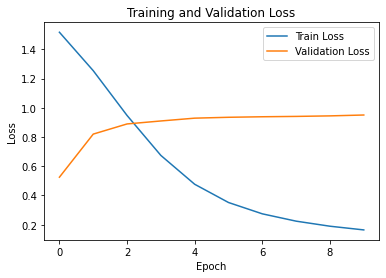

Accuracy: 0.9604
Precision: 0.9618
Recall: 0.9615
F1 Score: 0.9616


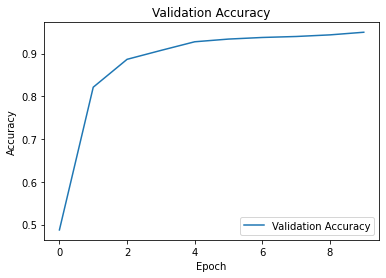

Test Results:


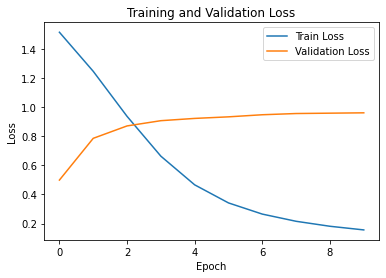

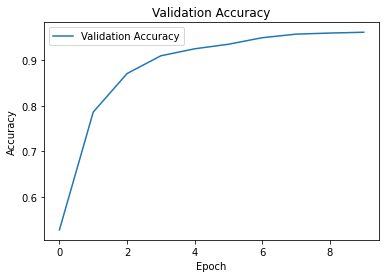

Test Results:
Accuracy: 0.9568
Precision: 0.9563
Recall: 0.9564
F1 Score: 0.9563


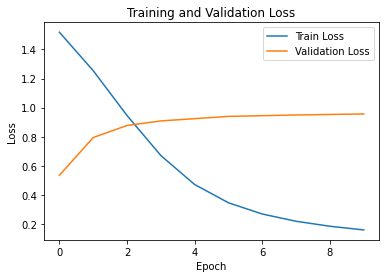

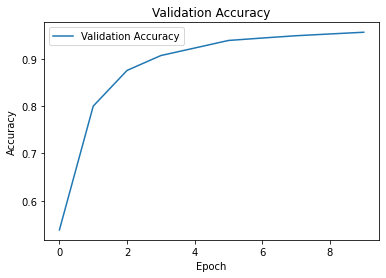

Test Results:
Accuracy: 0.9568
Precision: 0.9560
Recall: 0.9557
F1 Score: 0.9557
total end_time 1713139657.1492982
Rank 2: Training duration: 222.88 seconds
Accuracy: 0.9484
Precision: 0.9509
Recall: 0.9501
F1 Score: 0.9505
total end_time 1713139657.3702998
Rank 1: Training duration: 223.10 seconds
Accuracy: 0.9556
Precision: 0.9560
Recall: 0.9556
F1 Score: 0.9555
total end_time 1713139657.7058904
Rank 0: Training duration: 223.43 seconds


In [6]:
if __name__ == '__main__':
    world_size = 3
    # using bigger batch size to see the difference in AMP
    batch_size = 500 
    num_workers = 28
    processes = []
    for rank in range(world_size):
        p = mp.Process(target=train, args=(rank, world_size, batch_size, num_workers))
        p.start() 
        processes.append(p)
    for p in processes:
        p.join()

Inference: update

Average execution time per Epoch

Epoch 1: 15.776768922805786

Epoch 2: 14.764674425125122

Epoch 3: 14.613693952560425

Epoch 4: 14.961269855499268

Epoch 5: 14.67836308479309

Epoch 6: 14.735076189041138

Epoch 7: 14.853696823120117

Epoch 8: 14.395563125610352

Epoch 9: 14.547919034957886

Epoch 10: 15.185574531555176


So, the average execution time per Epoch is approximately 14.91 seconds.